In [ ]:
%load_ext autoreload
%autoreload 2

# Imports

In [ ]:
import mkl

mkl.set_num_threads(1)
from copy import deepcopy
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns

plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import (
    LOCALPATH,
    BASEPATH,
    interpolation_method,
    PHI_NGC,
    GAMMA_NGC,
    E0_NGC,
    LIVETIME,
    GEN2_FACTOR,
    ngc1068,
    txs0506,
    poles,
)
import settings as st
from tools import array_source_interp, poisson_llh, get_mids
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from aeff_calculations import setup_aeff_grid, aeff_rotation
from mephisto import Mephistogram
from scipy.interpolate import RegularGridInterpolator

# Settings

In [ ]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "improved-50": join(LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"),
}

# plot settings for different configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "IC-North",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [ ]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

# Background

In [ ]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)
bckg_histo["Gen-2"] = copy(bckg_histo["IceCube"])

In [ ]:
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# set up the interpolation function
sindec_mids_bg = -np.cos(np.deg2rad(zen))
logbg = np.log(flux_def["numu_total"])
minbg = np.min(logbg[np.isfinite(logbg)])
logbg[np.isnan(logbg)] = minbg
bg_rgi = RegularGridInterpolator(
    (e_grid, sindec_mids_bg),
    np.log(flux_def["numu_total"]),
    method=interpolation_method,
    bounds_error=False,
    fill_value=minbg,
)

In [ ]:
def background_rotation(rgi, detector_key, sindec_bins, logE_bins):
    sindec_mids = get_mids(sindec_bins)
    emids = get_mids(np.power(10, logE_bins))

    ss, em = np.meshgrid(sindec_mids, emids)
    numu_bg = np.exp(rgi((em, ss)))

    grid2d, eq_coords = setup_aeff_grid(
    numu_bg, sindec_mids, st.ra_mids, st.ra_width, log_int=True
    )

        # rotate the local background flux to equatorial coordinates
        # i.e. calculate the average bg flux per day in equatorial sin(dec)
    bg_i = Mephistogram(
        aeff_rotation(
            poles[detector_key]["lat"],
            poles[detector_key]["lon"],
            eq_coords,
            grid2d,
            st.ra_width,
            log_aeff=True,
        ).T,
        (sindec_bins, logE_bins),
        ("sin(dec)", "log(E/GeV)"),
        make_hist=False,
    )
    bg_i.histo[np.isnan(bg_i)] = np.min(bg_i[np.isfinite(bg_i)])
    return bg_i


test_bg = background_rotation(bg_rgi, detector_key="P-ONE", sindec_bins=st.sindec_bins, logE_bins=st.logE_bins+3)

# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [ ]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1) # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1) # normalize per logE_true

improved_eres.plot()

# PSF-Energy grid from the smearing matrix

In [ ]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# Flux definition

In [ ]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 and TXS0506 source parameters

In [ ]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(BASEPATH, "local/ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11

# TXS parameters
with open(join(BASEPATH, "local/txs_contour.pkl"), "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2.
PHI_TXS = 2.7E-20
E0_TXS = txs_contour["E0"] 

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")


In [ ]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad

# ... with txs declination
txs_src_config = copy(src_config)
txs_src_config["dec"] = txs0506.dec.rad
txs_bg_config = copy(bg_config)
txs_bg_config["dec"] = txs0506.dec.rad


## Check event numbers

In [ ]:
ident = "IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], grid_2d=e_psi2_grid, **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85


## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], grid_2d=e_psi2_grid, **txs_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("txs 0506+056:", np.sum(k_s))  # ~5

# Set up LLH function

In [ ]:
def ps_llh_single(
    x,
    aeff_factor_s,
    aeff_factor_b,
    bckg_flux,
    k_i,
    energy_resolution,
    e_0,
    phi_0,
    shape,
    verbose=False,
):
    """
    Calculate the log-likelihood using Poisson statistics for a single dataset assuming consistent properties.

    Parameters:
        x (list): Fit parameters.
            x[0]: Background normalization scaling.
            x[1]: Signal normalization scaling.
            x[2:]: Other signal parameters. See 'astro_flux' for further shapes and parameters.
        aeff_factor_s (float): Effective area factor for the signal.
        aeff_factor_b (float): Effective area factor for the background.
        bckg_flux (list): Background flux values.
        k_i (array-like): Observation/Asimov data.
        energy_resolution (float): Energy resolution.
        e_0 (float): Normalization energy. Default value is E0_NGC.
        phi_0 (float): Normalization flux. Default value is PHI_NGC.
        shape (str): Flux shape.
        verbose (bool, optional): Whether to print additional information. Default is False.

    Returns:
        float: -2 * Log-likelihood value calculated using Poisson statistics. See 'poisson_llh'.

    Note:
        This function assumes that there is only one dataset with consistent properties.
    """
    # Calculate the background contribution
    mu_b = (
        atmo_background(
            aeff_factor=aeff_factor_b,
            bckg_vals=bckg_flux,
            energy_resolution=energy_resolution,
        )
        * x[0]
    )
    # Calculate the signal contribution
    mu_s = astro_flux(
        aeff_factor_s,
        get_mids(np.power(10, aeff_factor_s.bins[1])),
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        # Print additional information if verbose mode is enabled
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))

    # Calculate the total expected events for the Poisson LLH
    mu_i = mu_s + mu_b

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


def ps_llh_multi(
    x,
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_bckg_flux,
    all_k,
    all_eres,
    shape,
    e_0,
    phi_0,
):
    """
    Calculate the total log-likelihood across multiple datasets with different properties.

    Parameters:
        x (list): Fit parameters.
        all_aeff_factor_s (list): List of effective area factors for the signal for each dataset.
        all_aeff_factor_b (list): List of effective area factors for the background for each dataset.
        all_bckg_flux (list): List of background flux values for each dataset.
        all_k (list): List of observation/Asimov data for each dataset.
        all_eres (list): List of energy resolutions for each dataset.
        shape (str): Flux shape.
        e_0 (float): Normalization energy.
        phi_0 (float): Normalization flux.

    Returns:
        float: Total log-likelihood value across all datasets.

    Note:
        This function assumes that there are multiple datasets with different properties.
    """
    llh = 0
    for i, aeffs in enumerate(all_aeff_factor_s):
        llh += ps_llh_single(
            x=x,
            aeff_factor_s=aeffs,
            aeff_factor_b=all_aeff_factor_b[i],
            bckg_flux=all_bckg_flux[i],
            k_i=all_k[i],
            energy_resolution=all_eres[i],
            e_0=e_0,
            phi_0=phi_0,
            shape=shape,
        )
    return llh


def setup_multi_llh(
    eres,
    conf,
    bg_config,
    sig_config,
    s_grid=e_psi2_grid,
    aeffs=aeff_2d,
    bckg_histo=bckg_histo,
    src_flux=ngc_flux,
    verbose=False,
    return_s_b=False,
):
    """
    Set up the components required for calculating the log-likelihood across multiple datasets.

    Parameters:
        eres (dict or array): Dictionary of arrays/mephistograms or single array/mephistogram representing the
                                  energy resolutions for each dataset. If a dictionary is provided,
                                  it should map dataset identifiers to their corresponding energy resolution.
                                  If a float is provided, the same energy resolution will be used for all datasets.
        conf (tuple): Tuple containing two lists - the first list represents dataset identifiers,
                      and the second list contains corresponding scaling factors corresponding to
                      either a lifetime scaling or effective-area scaling.
        verbose (bool, optional): Whether to print additional information. Default is False.
        return_s_b (bool, optional): Whether to return the individual signal and background histograms. Default is False.

    Returns:
        tuple: A tuple containing the following components for each dataset:
            - all_aeff_factor_s (list): List of effective area factors for the signal.
            - all_aeff_factor_b (list): List of effective area factors for the background.
            - all_k (list): List of observation/Asimov data.
            - all_bckg_flux (list): List of background flux values.
            - if return_s_b: all_k_s, all_k_b (lists): List of signal and background histograms

    Note:
        This function assumes that the configuration parameters and required functions (e.g., `calc_aeff_factor`,
        `atmo_background`, `astro_flux`, `array_source_interp`) are defined and accessible in the global namespace.
        If `eres` is a dictionary, each dataset identifier should have an associated energy resolution value.
        If `eres` is an  array/mephistogram, the same energy resolution will be used for all datasets.
    """

    all_aeff_factor_s = []
    all_aeff_factor_b = []
    all_k = []
    all_bckg_flux = []
    all_eres = []

    if return_s_b:
        all_k_s = []
        all_k_b = []

    for ident, factor in zip(*conf):
        current_sgrid = s_grid[ident] if isinstance(s_grid, dict) else s_grid
        current_bgrid = mephisto.like(current_sgrid, fill_value=1)
        current_bgrid.normalize()

        # Calculate effective area factors for background and signal
        aeff_factor_bckg = (
            calc_aeff_factor(aeffs[ident], grid_2d=current_bgrid, **bg_config) * factor
        )
        aeff_factor_signal = (
            calc_aeff_factor(aeffs[ident], grid_2d=current_sgrid, **sig_config) * factor
        )

        # Determine the energy resolution and background for the current dataset
        current_eres = eres[ident] if isinstance(eres, dict) else eres
        current_bckg = bckg_histo[ident] if isinstance(bckg_histo, dict) else bckg_histo

        # Calculate background flux
        bckg_flux = array_source_interp(
            bg_config["dec"], current_bckg, aeffs[ident].bin_mids[0], axis=1
        )

        # Calculate asimov data for atmospheric background
        k_b = atmo_background(
            aeff_factor=aeff_factor_bckg,
            bckg_vals=bckg_flux,
            energy_resolution=current_eres,
        )

        # Calculate asimov data for astrophysical signal with power law spectrum
        k_s = astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=get_mids(np.power(10, aeffs[ident].bins[1])),
            energy_resolution=current_eres,
            phi_scaling=1,
            flux_shape=src_flux,  # powerlaw
        )

        if verbose:
            print("Asimov data sum:")
            print("Background:", np.sum(k_b))
            print("Signal:", np.sum(k_s))

        all_aeff_factor_s.append(aeff_factor_signal)
        all_aeff_factor_b.append(aeff_factor_bckg)
        all_k.append(k_s + k_b)
        all_bckg_flux.append(bckg_flux)
        all_eres.append(current_eres)
        if return_s_b:
            all_k_s.append(k_s)
            all_k_b.append(k_b)
    if return_s_b:
        return (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        )
    else:
        return all_aeff_factor_s, all_aeff_factor_b, all_k, all_bckg_flux, all_eres

# Nominal PS fit

In [ ]:
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        baseline_eres,
        conf,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

# Scan energy threshold
## Standard PS and energy spectrum

Idea:
Rise the energy threshold for one or more detectors and see how point-source studies perform

### config

In [ ]:
ethresh_detector_configurations = {
    "IceCube": (["IceCube"], [1], ["s"]),
    "2 x IceCube": (["IceCube"], [2], ["s"]),
    "IceCube-Gen2": (["IceCube"], [GEN2_FACTOR], ["s"]),
    "P-ONE": (["IceCube", "P-ONE"], [1, 1], ["n", "s"]),
    "Plenum-1": (
        ["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"],
        [2, 1, 1, 1],
        ["n", "s", "s", "s"],
    ),
    "wild": (
        ["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"],
        [10, 11, 5, 8],
        ["n", "s", "s", "s"],
    ),
    "Plenum-2": (
        ["IceCube", "Gen-2", "P-ONE", "KM3NeT", "Baikal-GVD"],
        [2, 1, 1, 1, 1],
        ["n", "s", "s", "s", "s"],
    ),
    "Plenum-2-scaleAll": (
        ["IceCube", "Gen-2", "P-ONE", "KM3NeT", "Baikal-GVD"],
        [2, 1, 1, 1, 1],
        ["s", "s", "s", "s", "s"],
    ),
}
# "s" indicates scaling of energy threshold, "n" means no scaling

### analysis

In [ ]:
## NGC 1068 and TXS 0506+056
# analysis region in distance to source

### ENERGY SHIFT ###

verbose = False
optimize = True
results = []
sources = ["ngc", "txs"]
#detector_keys = ["Plenum-1"]  # , "Plenum-2"] #
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"] #
stepper = 0.1
for source, key, dE_i in product(sources, detector_keys, np.arange(0, 2, stepper)):
    conf = ethresh_detector_configurations[key]

    if source == "ngc":
        src_flux = ngc_flux
    elif source == "txs":
        src_flux = txs_flux

    current_src_config = deepcopy(src_config)
    current_src_config.pop("grid_2d", None)
    current_src_config["dec"] = 0
    current_bg_config = deepcopy(bg_config)
    current_bg_config.pop("grid_2d", None)
    current_bg_config["dec"] = 0

    shifted_aeffs = {}
    shifted_eres = {}
    shifted_bckg = {}
    shifted_psi_e = {}
    # shift the energy for all contributing histograms
    # atmo background needs to be re-calculated

    for sc, dk in zip(conf[2], conf[0]):
        tmp = deepcopy(aeff_2d[dk])
        tmp_e = deepcopy(improved_eres)
        tmp_sgrid = deepcopy(e_psi2_grid)

        if sc == "s":
            tmp.set_bins((tmp.bins[0], tmp.bins[1] + dE_i))
            tmp_sgrid.set_bins((tmp_sgrid.bins[0], tmp_sgrid.bins[1] + dE_i))
            tmp_e.set_bins(
                (tmp_e.bins[0] + dE_i, tmp_e.bins[1] + dE_i)
            )  # change both for true and reco E

            # re-calculate background
            tmp_bg = background_rotation(
                bg_rgi,
                detector_key=dk,
                sindec_bins=aeff_2d[dk].bins[0],
                logE_bins=tmp.bins[1],
            )
        else:
            tmp_bg = bckg_histo[dk]

        shifted_aeffs[dk] = tmp
        shifted_eres[dk] = tmp_e
        shifted_bckg[dk] = tmp_bg
        shifted_psi_e[dk] = tmp_sgrid

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        eres=shifted_eres,
        aeffs=shifted_aeffs,
        conf=conf[:2],
        s_grid=shifted_psi_e,
        bckg_histo=shifted_bckg,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        src_flux=src_flux,
        return_s_b=True,
    )
    if verbose:
        plt.figure()
        plt.title(f"{dE_i}, {key}, {source}, energy")
        for jj, k in enumerate(all_k):
            plt.plot(k.bin_mids[1], k.sum(axis=0), ds="steps-mid", ls="-", label="k")
            plt.plot(
                k.bin_mids[1],
                all_k_s[jj].sum(axis=0),
                ds="steps-mid",
                ls="-.",
                label="s",
            )
            plt.plot(
                k.bin_mids[1],
                all_k_b[jj].sum(axis=0),
                ds="steps-mid",
                ls="--",
                label="b",
            )
            if jj==0: plt.legend()
        plt.yscale("log")
        plt.show()
    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=src_flux.E0,
        phi_0=src_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    if optimize:
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, src_flux.gamma),
            approx_grad=True,
        )
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    else:
        pval = chi2.sf(out_bckg[1] - global_llh((1, 1, src_flux.gamma)), 2)
    significance = norm.isf(pval)
    for out in [out_bckg, out_comp]:
        if out[2]["warnflag"] == 2:
            print("WARNING, bg failed")
            print(out)

    results.append(
        {
            r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$": aeff_2d[dk].bins[1][0] +  dE_i,
            "Configuration": key,
            "Source": source,
            "PL index": rf"$\gamma$ = {src_flux.gamma}",
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(all_k_s),
            "n_b": np.sum(all_k_b),
        }
    )
    if optimize:
        results[-1].update(
            {
                "signal_Nbg": out_comp[0][0],
                "signal_Ns": out_comp[0][1],
                "signal_gamma": out_comp[0][2],
                "TS": out_bckg[1] - out_comp[1],
                "TS_check": out_bckg[1] - global_llh((1, 1, src_flux.gamma)),
            }
        )

    if verbose:
        print(f"{dE_i:1.2f}, {key}, {source}, energy")
        print("Asimov data sum:")
        print("Background:", np.sum(all_k_b))
        print("Signal:", np.sum(all_k_s))
        print("Signal fit parameters:", out_comp[0])
        print(
            "TS check:", global_llh((1, 1, src_flux.gamma)), "(fit: ", out_comp[1], ")"
        )
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print("Atmo-only normalization:", out_bckg[0])
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        # break


results = pd.DataFrame(results)
results.to_pickle(join(LOCALPATH, "ps_performance_e-thresh.pickle"))

In [ ]:
## NGC 1068 and TXS 0506+056
# analysis region in distance to source


### ENERGY THRESHOLD ###

verbose = False
optimize = True
results = []
sources = ["ngc", "txs"]
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"] #
enums = len(st.logE_reco_mids[st.logE_reco_mids <= 4.5]) + 1
stepper = 2

current_src_config = deepcopy(src_config)
#current_src_config["grid_2d"] = e_psi2_grid
current_src_config["dec"] = 0
current_bg_config = deepcopy(bg_config)
#current_bg_config["grid_2d"] = bckg_psi2_grid
current_bg_config["dec"] = 0

for source, key, ii in product(sources, detector_keys, range(0, enums, stepper)):
    conf = ethresh_detector_configurations[key]

    if source == "ngc":
        src_flux = ngc_flux
    elif source == "txs":
        src_flux = txs_flux



    shifted_aeffs = {}
    shifted_eres = {}
    # shift the energy for all contributing histograms
    # atmo background needs to be re-calculated
    energy_resolution_thresh = deepcopy(improved_eres)
    # set reco below threshold to zero
    energy_resolution_thresh.histo[:, :ii] = 0
    energy_resolution_thresh.histo[:ii] = 0
    
    for sc, dk in zip(conf[2], conf[0]):
        tmp = deepcopy(aeff_2d[dk])
        if sc == "s":
            tmp.histo[:ii] = 0
        shifted_aeffs[dk] = tmp
        shifted_eres[dk] = energy_resolution_thresh if sc=="s" else improved_eres

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        eres=shifted_eres,
        aeffs=shifted_aeffs,
        conf=conf[:2],
        s_grid=e_psi2_grid,
        bckg_histo=bckg_histo,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        src_flux=src_flux,
        return_s_b=True,
    )
    if verbose:
        plt.figure()
        plt.title(f"{dE_i}, {key}, {source}, energy")
        for jj, k in enumerate(all_k):
            plt.plot(k.bin_mids[1], k.sum(axis=0), ds="steps-mid", ls="-", label="k")
            plt.plot(
                k.bin_mids[1],
                all_k_s[jj].sum(axis=0),
                ds="steps-mid",
                ls="-.",
                label="s",
            )
            plt.plot(
                k.bin_mids[1],
                all_k_b[jj].sum(axis=0),
                ds="steps-mid",
                ls="--",
                label="b",
            )
            if jj==0: plt.legend()
        plt.yscale("log")
        plt.show()
    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=src_flux.E0,
        phi_0=src_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    if optimize:
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, src_flux.gamma),
            approx_grad=True,
        )
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    else:
        pval = chi2.sf(out_bckg[1] - global_llh((1, 1, src_flux.gamma)), 2)
    significance = norm.isf(pval)
    for out in [out_bckg, out_comp]:
        if out[2]["warnflag"] == 2:
            print("WARNING, bg failed")
            print(out)

    results.append(
        {
            r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$": st.logE_mids[ii],
            "Configuration": key,
            "Source": source,
            "PL index": rf"$\gamma$ = {src_flux.gamma}",
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(all_k_s),
            "n_b": np.sum(all_k_b),
        }
    )
    if optimize:
        results[-1].update(
            {
                "signal_Nbg": out_comp[0][0],
                "signal_Ns": out_comp[0][1],
                "signal_gamma": out_comp[0][2],
                "TS": out_bckg[1] - out_comp[1],
                "TS_check": out_bckg[1] - global_llh((1, 1, src_flux.gamma)),
            }
        )

    if verbose:
        print(f"{dE_i:1.2f}, {key}, {source}, energy")
        print("Asimov data sum:")
        print("Background:", np.sum(all_k_b))
        print("Signal:", np.sum(all_k_s))
        print("Signal fit parameters:", out_comp[0])
        print(
            "TS check:", global_llh((1, 1, src_flux.gamma)), "(fit: ", out_comp[1], ")"
        )
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print("Atmo-only normalization:", out_bckg[0])
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        # break


results = pd.DataFrame(results)
results.to_pickle(join(LOCALPATH, "ps_performance_e-thresh.pickle"))

### plotting

In [ ]:
results = pd.read_pickle(join(LOCALPATH, "ps_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 7))

ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Configuration",
    style="PL index",
    palette=[det_plotting[ident]["color"] for ident in detector_keys],
    lw=3, 
)
ax.set_ylim(0, 10)
ax.set_xlim(2, 4)
f.suptitle("Standard point-source significance", fontsize=18)
leg = ax.legend(
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.5, 1.4),
    frameon=False,
)
f.tight_layout()
f.subplots_adjust(hspace=0.15, top=0.7)
f.savefig("../../plots/ngc_paper/energy_threshold_significance_scan.pdf")

# NGC spectral shape + energy threshold

In [23]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
ident = "IceCube"
Gamma_cut = 2.0
logE_cut = 3.5 # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(
    PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)

## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        st.emids,
        baseline_eres,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        st.emids,
        baseline_eres,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut) 
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


flux_scaling_cut 1.4506383247202845
flux normalization before 5e-14 after 7.253191623601422e-14


##  baseline spectral fit

In [24]:

verbose = False
results = []
idents = ["IceCube", "Plenum-1", "Plenum-2"]
source = "ngc"

for ident in idents:
    conf = st.detector_configurations[ident]
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        improved_eres,  # select one resolution for all data sets
        conf,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        return_s_b=True,
        src_flux= ngc_cut_flux
    )

    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_cut_flux.E0,
        phi_0=ngc_cut_flux.norm,
    )
    pl_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_llh,
        x0=(1.2, 1.2, 3.0),
        bounds=([1E-2, 10], [1E-2, 10], [1, 6]),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 1.1, 1.9, 3.4),
        approx_grad=True,
    )
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    significance = norm.isf(pval)
    for out in [out_bckg, out_comp]:
        if out[2]["warnflag"] == 2:
            print("WARNING, bg failed")
            print(out)

    results.append(
        {
            "ident": ident,
            "Detector": det_plotting[ident]["plainlabel"],
            "Source": source,
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(all_k_s),
            "n_b": np.sum(all_k_b),
            "Energy Reco": "50% improved",
        }
    )

    if False:
        print("Asimov data sum:")
        print("Background:", np.sum(all_k_b))
        print("Signal:", np.sum(all_k_s))
        print("Signal fit parameters:", out_comp[0])
        print("Powerlaw fits (n_bg, n_s, gamma):", out_bckg[0])
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
    check = global_llh((1, 1, Gamma_cut, logE_cut))
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")

results = pd.DataFrame(results)

bckg params: [1.00474758 0.61378444 3.0578218 ]
P-VALUE: 0.17291919787494653 SIGNIFICANCE: 0.9426921383107286
pval check: 0.17261519776284967 ratio: 0.9982419527974175

bckg params: [1.00206932 0.61890576 3.01888047]
P-VALUE: 0.0014100801906226348 SIGNIFICANCE: 2.986689452523407
pval check: 0.0013975036164350977 ratio: 0.9910809510897505

bckg params: [1.00380861 0.61526632 3.04059125]
P-VALUE: 2.2144922110009855e-06 SIGNIFICANCE: 4.590163735170884
pval check: 2.1773113573574694e-06 ratio: 0.9832102124998174



## energy threshold scan

In [25]:
## NGC 1068 and TXS 0506+056
# analysis region in distance to source
verbose = False
optimize = False
results = []
enums = len(st.logE_reco_mids[st.logE_reco_mids <= 4]) + 1

### using improved energy resolution ###
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]

for ii, key in product(range(0, enums, stepper), detector_keys):
    conf = ethresh_detector_configurations[key]

    current_src_config = deepcopy(ngc_src_config)
    current_src_config["dec"] = 0
    current_bg_config = deepcopy(ngc_bg_config)
    current_bg_config["dec"] = 0

    # energy smearing
    energy_resolution_thresh = deepcopy(improved_eres)
    # set reco below threshold to zero
    energy_resolution_thresh.histo[:, :ii] = 0
    energy_resolution_thresh.histo[:ii] = 0
    
    for sc, dk in zip(conf[2], conf[0]):
        tmp = deepcopy(aeff_2d[dk])
        if sc == "s":
            tmp.histo[:ii] = 0
        shifted_aeffs[dk] = tmp
        shifted_eres[dk] = energy_resolution_thresh if sc=="s" else improved_eres

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        eres=shifted_eres,
        aeffs=shifted_aeffs,
        conf=conf[:2],
        s_grid=e_psi2_grid,
        bckg_histo=bckg_histo,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        src_flux=ngc_cut_flux,
        return_s_b=True,
    )
    
    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_cut_flux.E0,
        phi_0=ngc_cut_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
    global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2, 1.2, 3.0),
        bounds=([1E-2, 10], [1E-2, 10], [1, 6]),
        approx_grad=True,
    )
    bg_ts = out_bckg[1]

    # this fit is not really needed, but good for crosschecking the code
    if optimize:
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_cut_flux.gamma, ngc_cut_flux.e_cut),
            approx_grad=True,
        )
        pval = chi2.sf(bg_ts - out_comp[1], 1)
    else:
        pval = chi2.sf(bg_ts - global_llh((1, 1, ngc_cut_flux.gamma, ngc_cut_flux.e_cut)), 1)
    significance = norm.isf(pval)

    if optimize:
        for out in [out_bckg, out_comp]:
            if out[2]["warnflag"] == 2:
                print("WARNING, bg failed")
                print(out)

    results.append(
        {
            r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$": st.logE_reco_mids[ii],
            "Configuration": key,
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(all_k_s),
            "n_b": np.sum(all_k_b),
            "bg_Nbg": out_bckg[0][0],
            "bg_Ns": out_bckg[0][1],
            "bg_gamma": out_bckg[0][2],
        }
    )
    if optimize:
        results[-1].update({
            "signal_Nbg": out_comp[0][0],
            "signal_Ns": out_comp[0][1],
            "signal_gamma": out_comp[0][2],
            "TS": out_bckg[1] - out_comp[1],
            "TS_check": out_bckg[1] - global_llh((1, 1, ngc_cut_flux.gamma, ngc_cut_flux.e_cut)),
        })


    if verbose:
        print("Asimov data sum:")
        print("Background:", np.sum(all_k_b))
        print("Signal:", np.sum(all_k_s))
        print("Signal fit parameters:", out_comp[0])
        print(
            "TS check:", global_llh((1, 1, ngc_cut_flux.gamma, ngc_cut_flux.e_cut)), "(fit: ", out_comp[1], ")"
        )
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print("Atmo-only normalization:", out_bckg[0])
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        break
    if False:
        plt.figure()
        title = f"s: {significance:1.2f}, et:{logE_reco_mids[i]:1.2f}, idx:{i}, bg: "
        for ib in out_bckg[0]:
            title += f"{ib:1.2f}, "
        plt.title(title)
        for ii, ks in enumerate(all_k_s):
            p = plt.plot(ks.sum(axis=0), label= conf[0][ii])
            plt.plot(all_k[ii].sum(axis=0), ls="--", color=p[0].get_color())
            plt.plot(all_k_b[ii].sum(axis=0), ls=":", color=p[0].get_color())
        plt.yscale("log")
        plt.ylim(1E-3, 1E4)
        plt.legend()
        plt.show()
results = pd.DataFrame(results)
results.to_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))

## plotting

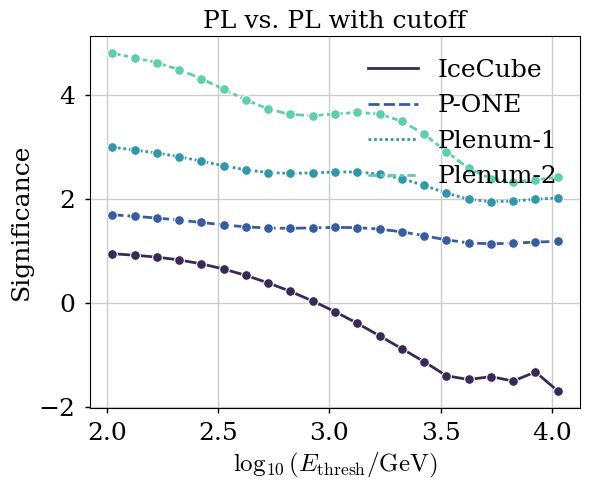

In [26]:
results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Configuration",
    style="Configuration",
    marker="o"
    #palette=[det_plotting[ident]["color"] for ident in detector_keys],
)
ax.set_title("PL vs. PL with cutoff")
ax.legend(loc=1, frameon=False)
f.tight_layout()
f.savefig("../../plots/ngc_paper/energy_threshold_significance_spectral_scan.pdf")

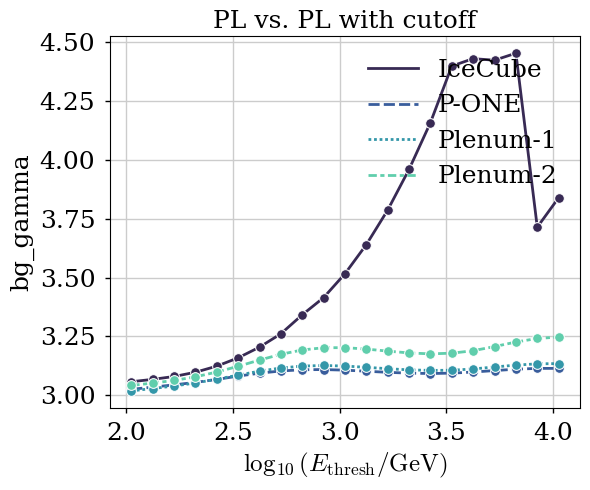

In [27]:
results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="bg_gamma",
    hue="Configuration",
    style="Configuration",
    marker="o"
    #palette=[det_plotting[ident]["color"] for ident in detector_keys],
)
ax.set_title("PL vs. PL with cutoff")
ax.legend(loc=1, frameon=False)
f.tight_layout()

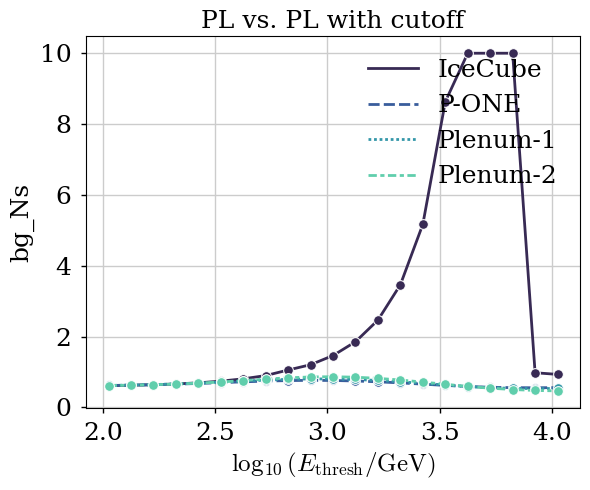

In [28]:
results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="bg_Ns",
    hue="Configuration",
    style="Configuration",
    marker="o"
    #palette=[det_plotting[ident]["color"] for ident in detector_keys],
)
ax.set_title("PL vs. PL with cutoff")
ax.legend(loc=1, frameon=False)
f.tight_layout()

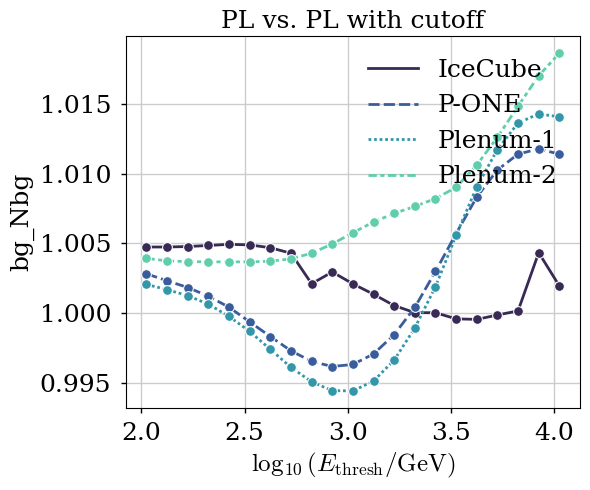

In [29]:
results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="bg_Nbg",
    hue="Configuration",
    style="Configuration",
    marker="o"
    #palette=[det_plotting[ident]["color"] for ident in detector_keys],
)
ax.set_title("PL vs. PL with cutoff")
ax.legend(loc=1, frameon=False)
f.tight_layout()

# combined plot

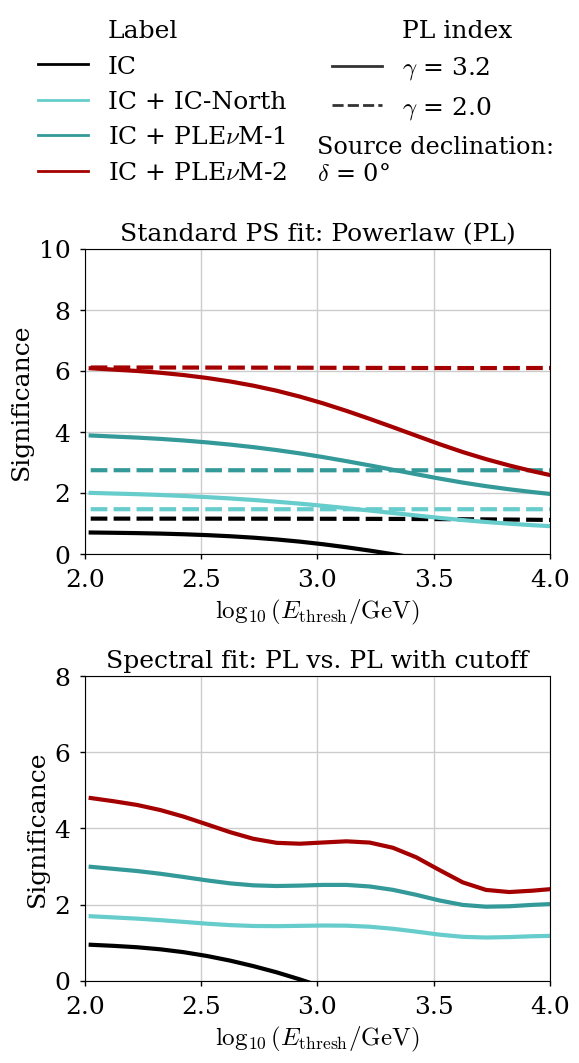

In [30]:
results = pd.read_pickle(join(LOCALPATH, "ps_performance_e-thresh.pickle"))
results["Label"] = "n"
results.loc[results["Configuration"]=="IceCube", "Label"] = "IC"
results.loc[results["Configuration"]=="P-ONE", "Label"] = "IC + IC-North"
results.loc[results["Configuration"]=="Plenum-1", "Label"] = r"IC + PLE$\nu$M-1"
results.loc[results["Configuration"]=="Plenum-2", "Label"] = r"IC + PLE$\nu$M-2"



f, axes = plt.subplots(nrows=2, figsize=(6, 12))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Label",
    style="PL index",
    palette=[det_plotting[ident]["color"] for ident in detector_keys],
    #label=[det_plotting[ident]["label"] for ident in detector_keys],
    #palette="magma",
    #palette=np.array(sns.color_palette("magma", n_colors=10))[[0, 5, 7]],
    ax=axes[0],
    lw=3,
)
ax.set_ylim(0, 10)
ax.set_xlim(2, 4)
ax.set_title("Standard PS fit: Powerlaw (PL)")
h, l = ax.axes.get_legend_handles_labels()
ax.axes.legend_.remove()
#ax.legend(h[-3:], l[-3:], frameon=True, loc=1, fontsize="x-large")
f.legend(
    h[-3:], l[-3:],
    loc="upper left",
    frameon=False,
    # fontsize=14,
    ncol=1,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)

results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
results["Label"] = "n"
results.loc[results["Configuration"]=="IceCube", "Label"] = "IC"
results.loc[results["Configuration"]=="P-ONE", "Label"] = "IC + IC-North"
results.loc[results["Configuration"]=="Plenum-1", "Label"] = r"IC + PLE$\nu$M-1"
results.loc[results["Configuration"]=="Plenum-2", "Label"] = r"IC + PLE$\nu$M-2"
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Label",
    palette=[det_plotting[ident]["color"] for ident in detector_keys],
    #label=[det_plotting[ident]["label"] for ident in detector_keys],
    #palette="magma",
    #palette=np.array(sns.color_palette("magma", n_colors=10))[[0, 5, 7]],
    lw=3,
    ax=axes[1],
)
ax.set_ylim(0, 8)
ax.set_xlim(2, 4)
ax.set_title("Spectral fit: PL vs. PL with cutoff")
ax.axes.legend_.remove()
# ax.legend(
#     h[:-3], l[:-3], loc=1, frameon=True, fontsize="x-large"
# )  # , bbox_to_anchor=(1, 0.5), frameon=False)
f.legend(
    h[:-3], l[:-3],
    loc="upper right",
    frameon=False,
    # fontsize=14,
    ncol=1,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
f.subplots_adjust(hspace=0.4, top=0.72)
ax.text(s="Source declination: \n"+r"$\delta$ = 0°", x=3, y=21., fontsize="xx-large")

#f.tight_layout()
f.savefig("../../plots/ngc_paper/energy_threshold_significance_spectral+PS_scan.pdf")
